# 매우 단순한 모델링하기 

데이터를 가지고 간단한 모델링을 수행해보겠습니다. 여기서는, 문제를 풀 때마다, 응답시간(time response)와 현재 풀고 있는 문제의 시도횟수가 어떤 관련이 있는지를 모델링해보겠습니다. 

- 독립변수: 응답시간의 기초 통계
- 종속변수: 문제의 시도 횟수 (정답률과 같은 개념)

In [1]:
from pyspark.storagelevel import StorageLevel
import numpy as np
import math
import re
import json
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark import sql
from pyspark.storagelevel import StorageLevel


## 샘플 데이터
데이터 보완 문제로 샘플 데이터는 업로드 하지 않았습니다

## 처리해야하는 로그 데이터의 구조

가공된 데이터는 아래와 같이 단순화되어 있습니다. 데이터는 8명의 사용자가 "Missing Number" 게임을 플레이한 정보를 담고 있습니다. 로그 데이터의 예시는 다음과 같습니다.

In [215]:
samples_save_missing.take(1)

[{'action': 'Start',
  'class': 'Game',
  'device': {'device_id': '5A23001564',
   'full_id': 'X-57-5A23001564',
   'group_id': 'X-57',
   'package': 'com.enuma.xprize',
   'period': 'Phase2'},
  'info': Row(log=Row(index=Row(global=1523, pack=1000), path='/GAME/sw-TZ_M_02/Free/MissingNumber-002', transition='legal'), session=Row(begin=Row(EAT='2018-05-23 12:13:38.604000+03:00', UTC=1527066818.604), index=78), time=Row(device=1527060098, network=Row(EAT='2018-05-23 13:25:31.626480+03:00', UTC=1527071131.62648, updated=True), time_from_prev=Row(global=0.03650403022766113, pack=0.03650403022766113), time_to_next=Row(global=28.686057090759277, pack=None))),
  'result': Row(connect_at=None, connect_error=None, day=None, expected=None, index=None, is_correct=None, level=None, page=None, position=None, quiz_type=None, response=None, time_delta=None, updated=None),
  'target': 'MissingNumber-002',
  'touch': [],
  '.func': 'game_Begin'}]

## 문제 풀이 단위로 로그 데이터를 묶기

우리의 분석 단위는 "문제 풀이"입니다. 문제 풀이는 다음과 같이, solve했거나 quit한 것이 데이터 한줄의 단위가 됩니다. 

- 문제를 시작(start)해서 정답을 맞춰서 (answer하고, result.is_correct==True) Solve함
- 문제를 시작(start)했다가 Quit함

우리가 만들고자하는 데이터 구조는 아래와 같습니다. 

```python
'pid': 각 줄에 대해 붙인 ID 값으로 , 고유합니다.  
'actions': 이 문제를 풀기 위해 사용자가 취한 행동(액션) 리스트
'times': 사용자가 취한 각 행동(액션)에 대해 걸린 시간으로, 이전 행동 시점 대비 현재 행동 시점의 타임스탬프 값의 차이로 계산됩니다.
'user': 사용자 ID 정보로, ['device']['full_id']에 들어있습니다. 
'g_name_level_problem': 문제풀이의 대상이 된 게임의 레벨, 문항번호 정보입니다. ['info']['log']['path']에 들어있습니다
'is_solve': 문제를 해결했는지 아니면 뒤로가기로 퇴장했는지를 나타냅니다. 
```

데이터 구조화는 아래와 같은 순서로 진행합니다.

1. Grouping: 사용자ID별로 로그를 그룹핑
2. FlatMap: 각 사용자에 대해 문제 풀이 단위로 로그 데이터를 묶어서 리턴함


In [ ]:
# 문제 단위 데이터
samples_grouped = samples_save_missing.map(lambda x:Row(**x)).groupBy(lambda x: x['device']['full_id'])


In [70]:
def group_result_by_problem(group):
    
    user, logs = group # (key, list) 순서쌍을 분해합니다.
    
    logs = sorted(logs, key=lambda x: x.info.log['index']['global']) # 목록을 정렬합니다.
    logs_by_problem = [] # user별 prolbem 단위로 묶인 logs

    basket_id = 0 # 바구니에 id를 부여합니다
    basket=[] # 바구니에 problem 하나가 시작해서 끝날 때까지 한 log씩 주어 담듯이, basket 이라는 list를 생성합니다
    history_basket={}    

    total_encounter_state = [] # 이전에 푼 적 있는지 기록하는 list
    solve_state = [] # 이전에 맞춘 적 있는지 기록하는 list
    quit_state = [] # 이전에 포기한 적 있는지 기록하는 list
    
    action_list = [] #액션을 넣는 리스트.
    time_list=[]
    
    for index, log in enumerate(logs):
        
        action_list.append(log['action'])
        time_list.append(log['info']['time']['time_from_prev']['global'])
        
        
        if log['action'] == 'Answer': # Answer하는 경우
            
            basket.append(log) # 우선 log를 바구니에 담습니다

            if log['result']['is_correct'] == False: # 만약 오답을 기입한 경우
                pass # 아무런 행동을 하지 않고 다음 log로 넘어갑니다
            
            else:

                history_basket={'user': log['device']['full_id'], \
                                'g_name_level_problem': log['target'], 
                                'is_solve': 'solve', \
                                }

                # 지금까지의 바구니를 basket_id와 함께 logs_by_problem에 append해준 후
                logs_by_problem.append(\
                                       {'pid':log['device']['full_id']+'_'+str(basket_id),\
                                        'actions':action_list,\
                                        'times':time_list,\
                                        #'plogs':basket, 
                                       'user':history_basket['user'], \
                                        'g_name_level_problem':history_basket['g_name_level_problem'], 
                                        'is_solve':history_basket['is_solve']
                                       })

                # 바구니를 비워줍니다. 이후 부터는 비운 바구니에 새로 log를 담게 됩니다
                basket=[]
                action_list=[]
                time_list=[]

                # 비우고 난 후 새로운 바구니에 새로운 id를 부여합니다
                basket_id += 1

                # history 바구니를 비워줍니다. 이후 부터는 비운 바구니에 새로 log를 담게 됩니다
                history_basket={}

                # 바구니를 비운 후 state 설정
                total_encounter_state.append(log['target'])
                solve_state.append(log['target'])


        elif log['action'] == 'Complete': # Complete하는 경우
            pass
                    
        elif log['action'] == 'Quit': # Quit한 경우, 마지막 오답인 경우라도 묶어줘야하므로 포함합니다
            
            # Quit에서 발생한 log는 별다른 정보가 없으므로 basket에 담지 않습니다
            
            # 대신 직전에 정의한 history_basket을 아래와 같이 'is_solve' 정보를 수정하여 새로 정의합니다

            if '#' not in logs[index-1]['target']: # 만약 Quit을 했는데, 이전 target에 문제번호가 없다면(시작하자마자 quit)
            
                # 첫문제에서 Quit 한 것이므로(Complete 직후 또는 Quit 직후) 아래와 같이 수정합니다
                history_basket={'user':log['device']['full_id'], \
                                     'g_name_level_problem':log['target']+("/#0"), 'is_solve':'quit', \
                                     }
                       
            else: # 만약 Quit을 했는데, 이전 target에 문제번호가 있다면(풀다가 quit)

                # 직전 문제에서 Quit 한 것이므로 아래와 같이 수정합니다
                history_basket = {'user':log['device']['full_id'], \
                                'g_name_level_problem':logs[index-1]['target'], 'is_solve':'quit', \
                                }
            
            # 지금까지의 바구니를 basket_id와 함께 logs_by_problem에 append해준 후
            logs_by_problem.append(\
                                   {'pid':log['device']['full_id']+'_'+str(basket_id),\
                                    'actions':action_list,\
                                    'times':time_list,\
                                   # 'plogs':basket, 
                                    'user':history_basket['user'], \
                                'g_name_level_problem':history_basket['g_name_level_problem'], 
                                    'is_solve':history_basket['is_solve']})
            
            # 바구니를 비워줍니다. 이후 부터는 비운 바구니에 새로 log를 담게 됩니다
            basket=[]
            action_list=[]
            time_list=[]

            # 비우고 난 후 새로운 바구니에 새로운 id를 부여합니다
            basket_id += 1

            # history 바구니를 비워줍니다. 이후 부터는 비운 바구니에 새로 log를 담게 됩니다
            history_basket={}
            
            # 바구니를 비운 후 state 설정
            total_encounter_state.append(log['target'])
            quit_state.append(log['target'])

            
        else:
            pass

    return logs_by_problem


In [71]:
problem_grouped = samples_grouped.flatMap(group_result_by_problem)
problem_grouped.persist(StorageLevel.DISK_ONLY)

PythonRDD[169] at RDD at PythonRDD.scala:48

끝으로, 우리는 중도 포기하지 않고 문제를 푼 것에만 관심을 가질 것이기에, 필터링을 해야합니다.

In [75]:
problem_filtered=problem_grouped.filter(lambda x:x['is_solve']=='solve')

In [76]:
problem_filtered.take(1)

[{'pid': 'X-57-6116002428_0',
  'actions': ['Start', 'Answer'],
  'times': [0.03669595718383789, 14.44014310836792],
  'user': 'X-57-6116002428',
  'g_name_level_problem': 'MissingNumber-001/#0',
  'is_solve': 'solve'}]

## 모델링하기

### 이상치(아웃라이어) 대체하기

응답 시간은 이상치가 많습니다. 기기 문제로 응답 시간이 음수로 나오거나, 오랫동안 켜놓고 다음 날에 접속하는 경우 응답 시간이 너무 길게 나올 수 있습니다. 이러한 이상치를 검출해서, 상한값이나 하한값으로 대체합니다.

In [184]:
def outlier_bottom_top(df):
    q1=np.percentile(df, 25)
    q3=np.percentile(df, 75)
    iqr=q3-q1
    bottom=q1-1.5*iqr
    top=q3+1.5*iqr
    return bottom,top

btm,top=outlier_bottom_top(problem_filtered.flatMap(lambda x:x['times']).collect())

def replace_outlier(row):
    global btm
    global top
    new_row=row
    times=new_row['times']
    times=[0 if t<0 else t for t in times]
    times=[top if t>top else t for t in times]
    new_row['times']=times
    return new_row

problem_filtered_replaced=problem_filtered.map(replace_outlier)
problem_filtered_replaced.take(1)

[{'pid': 'X-57-6116002428_0',
  'actions': ['Start', 'Answer'],
  'times': [0.03669595718383789, 12.802026391029358],
  'user': 'X-57-6116002428',
  'g_name_level_problem': 'MissingNumber-001/#0',
  'is_solve': 'solve'}]

## 관심 있는 Feature 뽑기

모델링을 위해 사용할 피쳐를 아래와 같이 디자인할 것입니다. 

```python
'time_first': 첫번째 응답시간
'time_min': 응답시간의 최소값
'time_max': 응답시간의 최대값
'time_mean': 응답시간의 평균
'time_median': 응답시간의 중위값
'time_final': 마지막 응답시간
'attempt_time': 답 입력 횟수
```

함수를 짜면

In [185]:
import numpy as np
def extract_features(row):
    new_row=dict()
    '''
    'time_first': 첫번째 응답시간
    'time_min': 응답시간의 최소값
    'time_max': 응답시간의 최대값
    'time_mean': 응답시간의 평균
    'time_median': 응답시간의 중위값
    'time_final': 마지막 응답시간
    'attempt_time': 답 입력 횟수
    '''
    new_row['time_first']=row['times'][0]
    new_row['time_min']=sorted(row['times'])[0]
    new_row['time_max']=sorted(row['times'])[-1]
    new_row['time_mean']=np.mean(row['times'])
    new_row['time_median']=np.median(row['times'])
    new_row['time_final']=row['times'][-1]
    new_row['attempt_time']=np.sum([1 for a in row['actions'] if a=='Answer'])
    
    return new_row

problem_features=problem_filtered_replaced.filter(lambda x:x!=None and x['times']!=None and x['actions']!=None).\
filter(lambda x:x['times']!=[]).map(extract_features)
    

In [186]:
problem_features.take(1)

[{'time_first': 0.03669595718383789,
  'time_min': 0.03669595718383789,
  'time_max': 12.802026391029358,
  'time_mean': 6.419361174106598,
  'time_median': 6.419361174106598,
  'time_final': 12.802026391029358,
  'attempt_time': 1}]

RDD를 데이터 프레임으로 바꿉니다. 

In [187]:
problem_collected=problem_features.collect()

In [188]:
import pandas as pd
df=pd.DataFrame(problem_collected)

## 분포를 시각화

Target에 해당하는 데이터를 히스토그램으로 시각화해보겠습니다. 결과를 보면 1~2번의 시도 이내에 문제를 solve한 경우가 대다수였습니다.

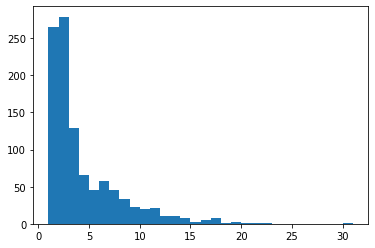

In [189]:
import matplotlib.pyplot as plt
plt.hist(df['attempt_time'],bins=30)
plt.show()

### Linear regression 모델 만들기

In [192]:
from sklearn.linear_model import LinearRegression
X=df.drop(['attempt_time'],axis=1)
y=df[['attempt_time']]
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

### Coefficient 프린트

In [193]:
coefs=pd.DataFrame(lr.coef_)
coefs.columns=X.columns
coefs

,time_first,time_min,time_max,time_mean,time_median,time_final
0,0.006218,1.526185,1.34574,-4.986403,1.70545,-0.048102


### R square

R square 값을 통해 회귀 모델의 정확도을 알 수 있습니다.

In [194]:
lr.score(X,y)

0.6702498357978728

### Feature selection

6개의 피쳐를 전부 사용한 것과, 몇개의 피쳐만을 사용한 것 간의 R square값을 비교했더니, 전부 사용한 것이 더 높았습니다.

In [195]:
lr = LinearRegression()
lr.fit(X, y)
temp=lr.score(X,y)
temp_columns=list(X.columns)

while(True):
    
    if len(temp_columns)==1:
        break
    
    #하나씩 뺸다. 
    lst=[]
    col_lst=[]
    
    for i in range(len(temp_columns)):
        temp_temp_cols=[t for t in temp_columns]
        temp_temp_cols.pop(i)
        lr = LinearRegression()
        lr.fit(X[temp_temp_cols], y)
        s=lr.score(X[temp_temp_cols],y)
        lst.append(s)
        col_lst.append(cols)
    
    s=np.max(lst)
    if temp<s:
        temp_columns=col_lst[lst.index(s)]
    elif temp>=s:
        break

temp,temp_columns

(0.6702498357978728,
 ['time_first',
  'time_min',
  'time_max',
  'time_mean',
  'time_median',
  'time_final'])